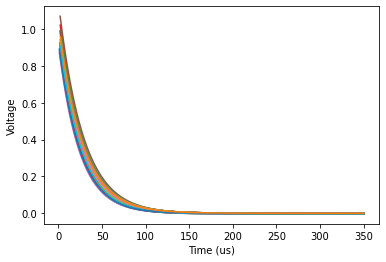

In [6]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import glob
%matplotlib inline

# Decay Function
def decay(x,a,c):
    # c = tau
    # Changed b to be max V (initial voltage V0 that decays) instead of optimizable variable
    return a + max_v*np.exp(-x/c)

data_path = 'ringdown raw data/11-05-2021 633/20211105-0002/'
data_files = glob.glob(data_path + '*.csv')
ring_downs = []
raw_ring_downs = []

for i in data_files:
    #plt.figure()
# Pandas DataFrame of Picoscope Data
    data = pd.read_csv(i, skiprows=1) 
# Start and End position based on max Voltage and general position of user-defined end marker    
    start_full = data.loc[(data['(V)'] == max(data['(V)']))].idxmax()[0]
    end_full = (data['(us)'] >= 350).idxmax()
# Finding Range of Voltage values to determine the 90-10 value range      
    vrange = max(data['(V)'][start_full:end_full]) - min(data['(V)'][start_full:end_full])
    vmax = max(data['(V)'][start_full:end_full]) - (0.1 * vrange)
    vmin = min(data['(V)'][start_full:end_full]) + (0.1 * vrange)

# Start and End positions based on 90-10 value range
    start = (data['(V)'][start_full:end_full] <= vmax).idxmax()
    end = (data['(V)'][start_full:end_full] <= vmin).idxmax()
    max_v = max(data['(V)'][start_full:end_full])
    
# Curve Fitting
    time = data['(us)'][start_full:end_full]
    voltage = data['(V)'][start_full:end_full]
    popt, pcov = curve_fit(decay, time.values, voltage.values)
    
# R-Squared    
    residuals = voltage - decay(time, *popt)
    res_ss = np.sum(residuals**2)
    ss_tot = np.sum((voltage - np.mean(voltage))**2)
    r_squared = 1 - (res_ss / ss_tot)
    
# Calculating Raw ringdown time similar to software calculation    
    raw_ringdown = max(data['(us)'][start:end])-min(data['(us)'][start:end])

    
# Constant to convert tau to 90-10 ringdown time where t = tau * ln(90/10)
    tconst = np.log(9)
    
# Compiling ring down data     
    limit = 0.99
    if r_squared >= limit:
        ring_downs.append(popt[1]*tconst)
        raw_ring_downs.append(raw_ringdown)
        #print(max_v, decay(time.values[0], *popt))
    else:
        print('Rejecting poor fit.')
    
    #plt.plot(time, voltage)
    plt.plot(time, decay(time, *popt))
    plt.xlabel('Time (us)')
    plt.ylabel('Voltage')
    #plt.text(30,0.8, 'fit calc\'d ringdown = ' +str(popt[1]*tconst) + ' (us)')
    #plt.text(30,0.7, 'raw calc\'d ringdown = ' + str(raw_ringdown) + ' (us)')
    #plt.text(30,0.6, 'r^2 = ' + str(r_squared))


In [7]:
# Summary Statistics
print('Minimum R-Squared: ', limit)    
print('Successful ringdown fits: ', len(ring_downs),)
print('Average calculated ringdown time: ', np.mean(ring_downs), ' (us)')
print('Average raw ringdown time: ', np.mean(raw_ring_downs), ' (us)')
print('Calculated ringdown Standard Deviation: ', np.std(ring_downs), ' (us)')
print('Raw ringdown Standard Deviation: ', np.std(raw_ring_downs), ' (us)')

Minimum R-Squared:  0.99
Successful ringdown fits:  32
Average calculated ringdown time:  58.7316371337043  (us)
Average raw ringdown time:  55.54824842812499  (us)
Calculated ringdown Standard Deviation:  3.2666430432132145  (us)
Raw ringdown Standard Deviation:  3.404347960070466  (us)
